In [2]:
# I import the necessary libraries for analysis and visualization and set a clean style for visuals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")

In [3]:
# I load the dataset with customer orders and check its structure
orders = pd.read_csv("customer_orders.csv")
print("Dataset shape:", orders.shape)
print("Data types:")
print(orders.dtypes)
print("First few rows:")
print(orders.head())

Dataset shape: (110420, 6)
Data types:
order_id         int64
customer_id      int64
order_date      object
order_amount     int64
platform        object
category        object
dtype: object
First few rows:
   order_id  customer_id  order_date  order_amount platform     category
0         1       115795  2023-01-01           214   mobile  smartphones
1         2       100860  2023-01-01            42   mobile  smartphones
2         3       105390  2023-01-01           693  desktop  smartphones
3         4       111964  2023-01-01           180   mobile      laptops
4         5       111284  2023-01-01           157  desktop  smartphones


In [4]:
# I convert platform and category to categorical type to improve performance and memory usage
orders["platform"] = orders["platform"].astype("category")
orders["category"] = orders["category"].astype("category")
print("Data types after converting to category:")
print(orders.dtypes)

Data types after converting to category:
order_id           int64
customer_id        int64
order_date        object
order_amount       int64
platform        category
category        category
dtype: object


In [5]:
# I convert order_date to datetime format in order to effectively work with dates
orders["order_date"] = pd.to_datetime(orders["order_date"])
print("Data types after date conversion:")
print(orders.dtypes)

Data types after date conversion:
order_id                 int64
customer_id              int64
order_date      datetime64[ns]
order_amount             int64
platform              category
category              category
dtype: object


In [6]:
# I group by customer_id to find the date of their first order
first_orders = orders.groupby("customer_id")["order_date"].min().reset_index()
first_orders

,customer_id,order_date
0,100000,2023-07-23
1,100001,2023-03-03
2,100002,2023-03-25
3,100003,2023-06-05
4,100004,2023-09-28
...,...,...
19916,119995,2023-04-20
19917,119996,2023-02-14
19918,119997,2023-04-30
19919,119998,2023-07-19


In [7]:
# I rename the columns for clarity
first_orders.columns = ["customer_id", "first_order_date"]
print("First orders data:")
print(first_orders.head())

First orders data:
   customer_id first_order_date
0       100000       2023-07-23
1       100001       2023-03-03
2       100002       2023-03-25
3       100003       2023-06-05
4       100004       2023-09-28


In [8]:
# I merge the first order date back to the original orders data
orders = orders.merge(first_orders, on="customer_id", how="left")
print("Data after merging:")
print(orders.head())

Data after merging:
   order_id  customer_id order_date  order_amount platform     category  \
0         1       115795 2023-01-01           214   mobile  smartphones   
1         2       100860 2023-01-01            42   mobile  smartphones   
2         3       105390 2023-01-01           693  desktop  smartphones   
3         4       111964 2023-01-01           180   mobile      laptops   
4         5       111284 2023-01-01           157  desktop  smartphones   

  first_order_date  
0       2023-01-01  
1       2023-01-01  
2       2023-01-01  
3       2023-01-01  
4       2023-01-01  


In [9]:
# I create a cohort date by extracting the year and month of the first purchase
orders["cohort_date"] = orders["first_order_date"].dt.to_period("M")
orders["cohort_date"]

,cohort_date
0,2023-01
1,2023-01
2,2023-01
3,2023-01
4,2023-01
...,...
110415,2023-03
110416,2023-10
110417,2023-06
110418,2023-02


In [10]:
# I check the unique cohort dates to see the range
print("Unique cohort dates:", orders["cohort_date"].unique())

Unique cohort dates: <PeriodArray>
['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07',
 '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01']
Length: 13, dtype: period[M]


In [11]:
# I calculate how many days have passed since the first order for each purchase
orders["days_since_first"] = (orders["order_date"] - orders["first_order_date"]).dt.days

In [12]:
# I filter orders to keep only those within 10 days from the first purchase
orders_10days = orders[orders["days_since_first"] <= 10]
print("Orders within 10 days shape:", orders_10days.shape)

Orders within 10 days shape: (22111, 9)


In [13]:
# I calculate the size of each cohort (number of unique customers)
cohort_size = orders.groupby(["cohort_date", "platform", "category"])["customer_id"].nunique().reset_index()
cohort_size

<ipython-input-13-43cc9cc52a3d>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_size = orders.groupby(["cohort_date", "platform", "category"])["customer_id"].nunique().reset_index()


,cohort_date,platform,category,customer_id
0,2023-01,desktop,accessories,792
1,2023-01,desktop,laptops,785
2,2023-01,desktop,smartphones,1357
3,2023-01,desktop,tablets,436
4,2023-01,desktop,wearables,407
...,...,...,...,...
125,2024-01,mobile,accessories,1
126,2024-01,mobile,laptops,0
127,2024-01,mobile,smartphones,0
128,2024-01,mobile,tablets,0


In [14]:
# I rename the column to make it clear
cohort_size.columns = ["cohort_date", "platform", "category", "cohort_size"]
print("Cohort sizes:")
print(cohort_size.head())

Cohort sizes:
  cohort_date platform     category  cohort_size
0     2023-01  desktop  accessories          792
1     2023-01  desktop      laptops          785
2     2023-01  desktop  smartphones         1357
3     2023-01  desktop      tablets          436
4     2023-01  desktop    wearables          407


In [15]:
# I calculate the total revenue for each cohort within 10 days
revenue_10days = orders_10days.groupby(["cohort_date", "platform", "category"])["order_amount"].sum().reset_index()
print("Revenue within 10 days:")
print(revenue_10days.head())

Revenue within 10 days:
  cohort_date platform     category  order_amount
0     2023-01  desktop  accessories         33756
1     2023-01  desktop      laptops         27619
2     2023-01  desktop  smartphones         57645
3     2023-01  desktop      tablets         18005
4     2023-01  desktop    wearables         11562


<ipython-input-15-d893d78a8315>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_10days = orders_10days.groupby(["cohort_date", "platform", "category"])["order_amount"].sum().reset_index()


In [16]:
# I merge the cohort size and revenue data
cohort_analysis = cohort_size.merge(revenue_10days, on=["cohort_date", "platform", "category"], how="left")
cohort_analysis

,cohort_date,platform,category,cohort_size,order_amount
0,2023-01,desktop,accessories,792,33756
1,2023-01,desktop,laptops,785,27619
2,2023-01,desktop,smartphones,1357,57645
3,2023-01,desktop,tablets,436,18005
4,2023-01,desktop,wearables,407,11562
...,...,...,...,...,...
125,2024-01,mobile,accessories,1,610
126,2024-01,mobile,laptops,0,0
127,2024-01,mobile,smartphones,0,0
128,2024-01,mobile,tablets,0,0


In [17]:
# I calculate the average LTV (revenue per customer)
cohort_analysis["avg_ltv"] = cohort_analysis["order_amount"] / cohort_analysis["cohort_size"]
print("Cohort analysis with LTV:")
print(cohort_analysis.head())

Cohort analysis with LTV:
  cohort_date platform     category  cohort_size  order_amount    avg_ltv
0     2023-01  desktop  accessories          792         33756  42.621212
1     2023-01  desktop      laptops          785         27619  35.183439
2     2023-01  desktop  smartphones         1357         57645  42.479735
3     2023-01  desktop      tablets          436         18005  41.295872
4     2023-01  desktop    wearables          407         11562  28.407862


In [18]:
# I format the result to match the expected output
cohort_analysis["cohort_date"] = cohort_analysis["cohort_date"].astype(str)
result = cohort_analysis[["cohort_date", "platform", "category", "cohort_size", "avg_ltv"]]
result

,cohort_date,platform,category,cohort_size,avg_ltv
0,2023-01,desktop,accessories,792,42.621212
1,2023-01,desktop,laptops,785,35.183439
2,2023-01,desktop,smartphones,1357,42.479735
3,2023-01,desktop,tablets,436,41.295872
4,2023-01,desktop,wearables,407,28.407862
...,...,...,...,...,...
125,2024-01,mobile,accessories,1,610.000000
126,2024-01,mobile,laptops,0,NaN
127,2024-01,mobile,smartphones,0,NaN
128,2024-01,mobile,tablets,0,NaN


In [20]:
# I replace NaN with 0 in the avg_ltv column for cases where there was no revenue
result["avg_ltv"] = result["avg_ltv"].fillna(0)
print("Cohort Analysis Results:")
print(result)

Cohort Analysis Results:
    cohort_date platform     category  cohort_size     avg_ltv
0       2023-01  desktop  accessories          792   42.621212
1       2023-01  desktop      laptops          785   35.183439
2       2023-01  desktop  smartphones         1357   42.479735
3       2023-01  desktop      tablets          436   41.295872
4       2023-01  desktop    wearables          407   28.407862
..          ...      ...          ...          ...         ...
125     2024-01   mobile  accessories            1  610.000000
126     2024-01   mobile      laptops            0    0.000000
127     2024-01   mobile  smartphones            0    0.000000
128     2024-01   mobile      tablets            0    0.000000
129     2024-01   mobile    wearables            0    0.000000

[130 rows x 5 columns]


<ipython-input-20-3d23b2876895>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["avg_ltv"] = result["avg_ltv"].fillna(0)


In [21]:
# I analyze the results to find insights
highest_ltv = result.loc[result["avg_ltv"].idxmax()]
print("Cohort with the highest LTV:")
print(highest_ltv)

Cohort with the highest LTV:
cohort_date        2024-01
platform            mobile
category       accessories
cohort_size              1
avg_ltv              610.0
Name: 125, dtype: object


In [22]:
# I compare average LTV between platforms
platform_ltv = result.groupby("platform")["avg_ltv"].mean()
print("\nAverage LTV by platform:")
print(platform_ltv)


Average LTV by platform:
platform
desktop    67.266005
mobile     79.149715
Name: avg_ltv, dtype: float64


<ipython-input-22-cd067933369c>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  platform_ltv = result.groupby("platform")["avg_ltv"].mean()


<ipython-input-23-4509ce37fee6>:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = result.pivot_table(index="cohort_date", columns="platform", values="avg_ltv")


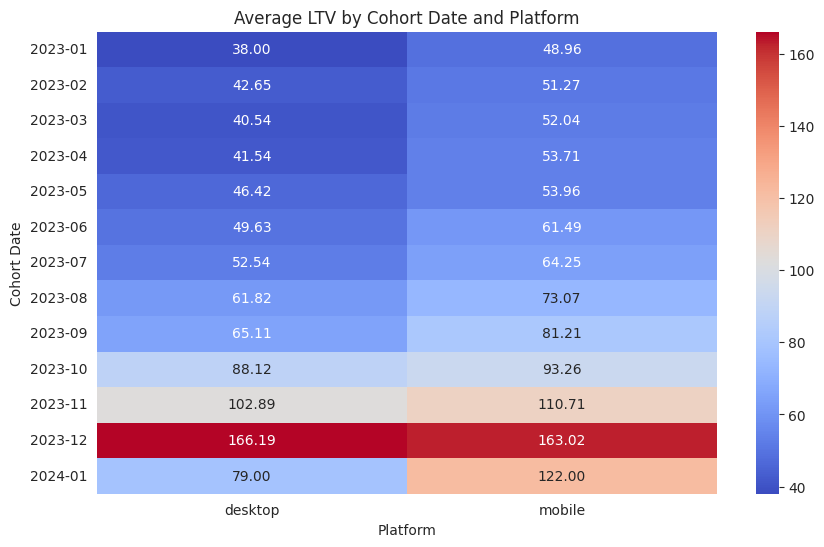

<Figure size 640x480 with 0 Axes>

In [23]:
# I create a heatmap to visualize avg_ltv by cohort date and platform
pivot_table = result.pivot_table(index="cohort_date", columns="platform", values="avg_ltv")
plt.figure(figsize=[10, 6])
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average LTV by Cohort Date and Platform")
plt.xlabel("Platform")
plt.ylabel("Cohort Date")
plt.show()
plt.savefig("heatmap_ltv.png")  # Saving the heatmap for GitHub

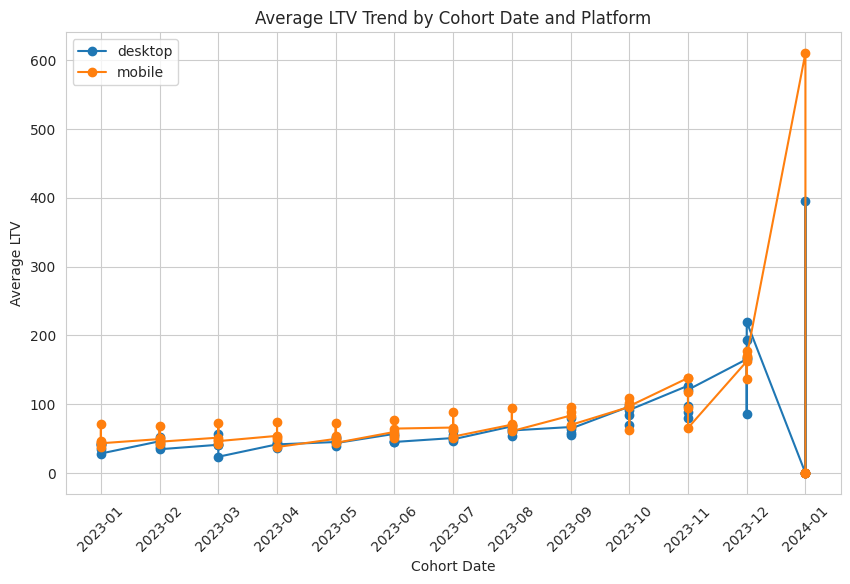

<Figure size 640x480 with 0 Axes>

In [24]:
# I create a line plot to show the trend of avg_ltv over cohort dates for each platform
plt.figure(figsize=[10, 6])
for platform in result["platform"].unique():
    platform_data = result[result["platform"] == platform]
    plt.plot(platform_data["cohort_date"], platform_data["avg_ltv"], marker="o", label=platform)
plt.title("Average LTV Trend by Cohort Date and Platform")
plt.xlabel("Cohort Date")
plt.ylabel("Average LTV")
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.savefig("lineplot_ltv.png")  # Saving the line plot for GitHub